<a href="https://colab.research.google.com/github/blawok/Toxic_Comments_Classification/blob/master/toxic_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxic comment classification

 In this project we analyzed toxic comment dataset from Kaggle challenge - https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview.
Our goal was to implement model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based in comments.

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments. That leads to a need of system to classify such statements and automatically block them or clean them.

In this notebook we will try to solve this problem.

**Disclaimer: the dataset contains text that may be considered profane, vulgar, or offensive.**

### Google Colab

We highly advise to use Google Colab tool while using that notebook - both for readability reasons and performance improvement (due to Google's GPU embedded in Colab).

Since we have shared a folder on Google Drive with data/presaved models it is avised to mount your Google Drive into this Colab by running following chunk of code and following instructions:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


If you have added the folder which we shared with you (called Toxic_Comments) to your Google Drive, everything should work smoothly from now on. 

We recommend you to use *Table of contents* from the sidebar on left - whole structure of this notebook is made on that.

# Load libraries and datasets

Followig cell allows you to install two packages that are not installed in Colab by default.

In [0]:
# !pip install vaderSentiment
# !pip install pyldavis

In [5]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import warnings
import nltk
import os
import pickle 
import pyLDAvis

warnings.simplefilter("ignore", DeprecationWarning)
nltk.download('stopwords')
nltk.download('wordnet')

%matplotlib inline
import matplotlib.pyplot as plt

from pyLDAvis import sklearn as sklearn_lda
from itertools import combinations
from wordcloud import WordCloud ,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Load datasets

In [0]:
train = pd.read_csv('drive/My Drive/Toxic_Comments/data/train.csv')
test = pd.read_csv('drive/My Drive/Toxic_Comments/data/test.csv')
test_labels = pd.read_csv('drive/My Drive/Toxic_Comments/data/test_labels.csv')
test_set = pd.concat([test.reset_index(drop=True), test_labels.iloc[:,1:]], axis=1)
test_set = test_set[test_set.toxic != -1]

Remove stopwords

In [0]:
stopwords = nltk.corpus.stopwords.words('english')
train['clean_comments'] = train['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
test_set['clean_comments'] = test_set['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

# EDA

First let's look how the data looks like, we've got one column for comments (already cleaned) and six columns for categories - binary values:


*   1 - comment is of this category
*   0 - it is not of this category



In [12]:
train.iloc[:,2:].head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comments
0,0,0,0,0,0,0,Explanation Why edits made username Hardcore M...
1,0,0,0,0,0,0,D'aww! He matches background colour I'm seemin...
2,0,0,0,0,0,0,"Hey man, I'm really trying edit war. It's guy ..."
3,0,0,0,0,0,0,""" More I can't make real suggestions improveme..."
4,0,0,0,0,0,0,"You, sir, hero. Any chance remember page that'..."


Let's see how the distributions vary by each category:





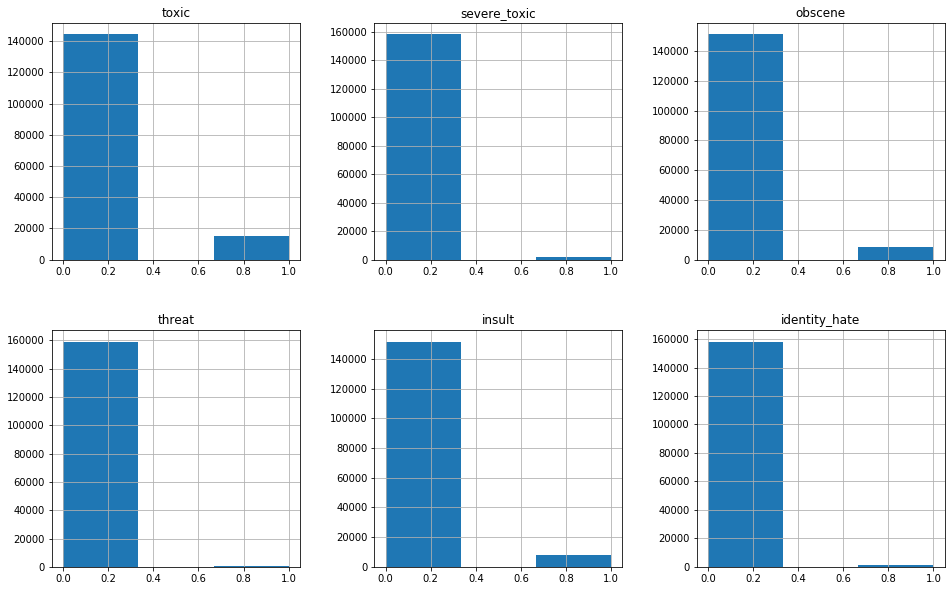

In [14]:
fig, axes = plt.subplots(2,3, figsize=(16, 10))
i = 2
for triaxis in axes:
    for axis in triaxis:
        train.hist(column = train.columns[i], bins = 3, ax=axis)
        i = i+1
plt.show()

Toxic, obscene and insult categories have the most positive (=1) observations. Let see if it is the same for test set.

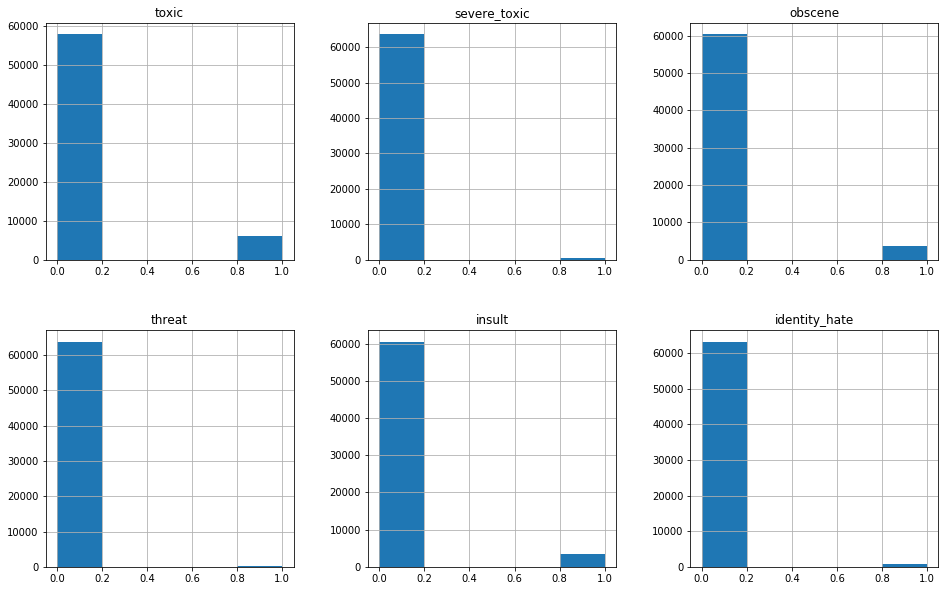

In [13]:
fig, axes = plt.subplots(2,3, figsize=(16, 10))
i = 2
for triaxis in axes:
    for axis in triaxis:
        test_set.hist(column = test_set.columns[i], bins = 5, ax=axis)
        i = i+1
plt.show()

Fortunately, the distribution looks very similar to the training set, so there would not be any problems with imbalanced data between train and test.


Are there any rows with missing data?

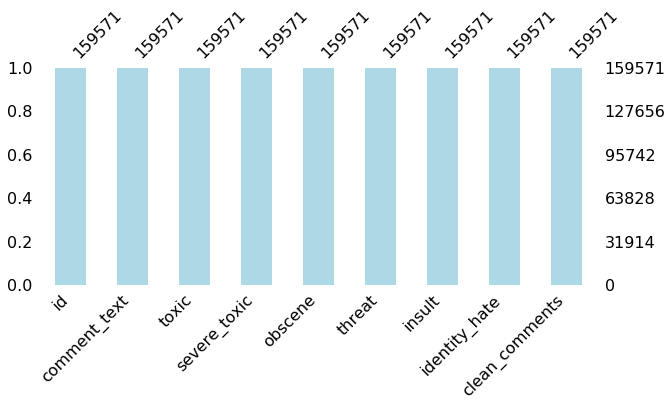

In [15]:
msno.bar(train, color='lightblue', figsize=(10,4))

All columns have data in 100% of observations.

Let's explore comments!

In [20]:
lens = train.clean_comments.str.len()
print(f'Mean of the comments length: {round(lens.mean(),1)}')
print(f'Standard deviation of the comments length: {round(lens.std(),1)}')
print(f'Max of the comments length: {lens.max()}')
print(f'Min of the comments length: {lens.min()}')

Mean of the comments length: 286.4
Standard deviation of the comments length: 442.3
Max of the comments length: 5000
Min of the comments length: 4


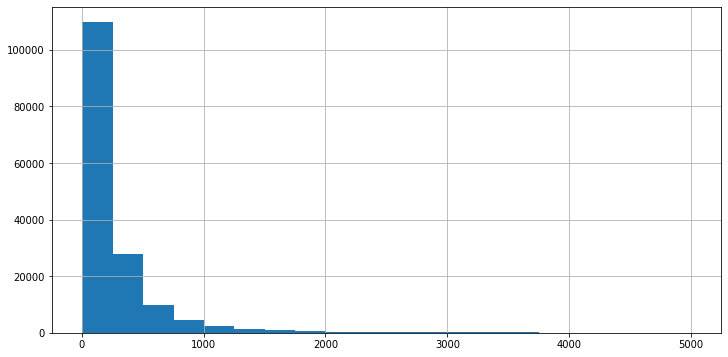

In [21]:
lens.hist(figsize = (12,6), bins = 20)

We clearly see that the distribution of lengths is right skewed, so we are dealing mostly with short comments.

Let's see if the categories are correlated between each other.

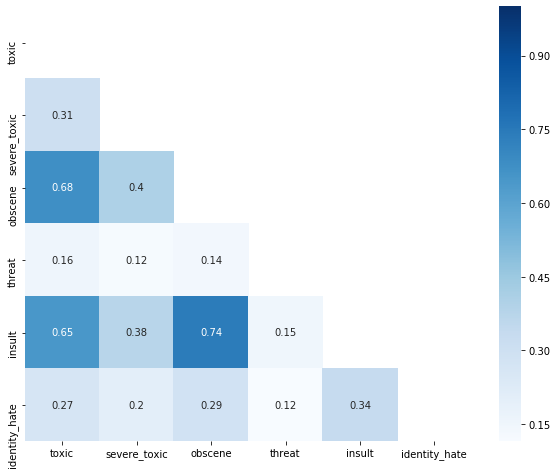

In [0]:
label_cols = train.iloc[:,2:].columns
train['other'] = 1-train[label_cols].max(axis=1)
temp_df=train.iloc[:,2:-1]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,
            cmap="Blues",
            mask=mask)

We can see that **insult** is highly correlated with **obscene** and **toxic**, as well as **obscene** is higly correlated with **toxic**. We may expect that those categories will appear together - maybe classifier will take advantage of that?

# Text Mining Analysis

Let's go a little deeper in text mining analysis!

### Wordclouds

We will start with simple wordclouds to get us familiar with the comments posted on the Wikipedia pages. 

**The dataset contains text that may be considered profane, vulgar, or offensive.**

In [0]:
stopword=set(STOPWORDS)
stopword_add = ['NIGGER', 'JEW', 'FUCK']
for word in stopword_add:
  stopword.add(word)

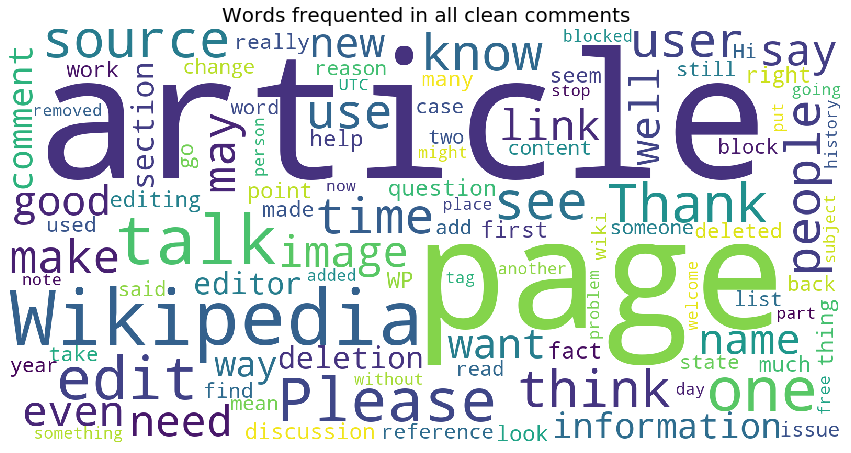

In [40]:
subset=train
text=subset.clean_comments.values
wc= WordCloud(background_color="white",
              max_words=100,
              stopwords=stopword,
              collocations=False,
              width=1600,
              height=800)
wc.generate(" ".join(text))
plt.figure(figsize=(15,10))
plt.tight_layout(pad=0)
plt.axis("off")
plt.title("Words frequented in all clean comments", fontsize=20)
plt.imshow(wc)
plt.show()

It may look quite OK, nothing toxic or insulting, we can easily deduce that the dataset consists of some kind of discussion about Wikipedia's articles.

However, if we limit the data only to *identity hate* comments, it starts getting nasty.

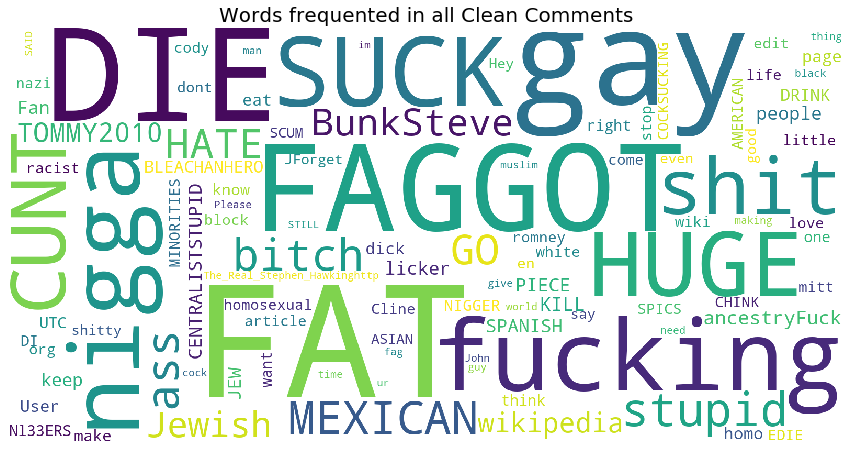

In [38]:
subset=train[train.identity_hate==1]
text=subset.clean_comments.values
wc= WordCloud(background_color="white",
              max_words=100,
              stopwords=stopword,
              collocations=False,
              width=1600,
              height=800)
wc.generate(" ".join(text))
plt.figure(figsize=(15,10))
plt.tight_layout(pad=0)
plt.axis("off")
plt.title("Words frequented in identity hate clean comments", fontsize=20)
plt.imshow(wc)
plt.show()

Even though we removed some of the most insulting phrases, we still see that those comments were severly vulgar and insulting.
 
They are targeting few groups - Homosexuals, Afroamericans, Mexicans and Jews. We have never suspected that Wikipedia's pages would be that vulgar.

### Topic modelling per category

Let's see if we can gain more information by topic modelling. We will focus on toxic comments, because they gather the most comments from multiple categories.

We will start by simply plotting most common words from the corpus.

In [0]:
def plot_most_common_words(count_data, count_vectorizer):

    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(counts, x_pos, palette="Blues_d", orient = 'h')
    plt.yticks(x_pos, words) 
    plt.xlabel('counts')
    plt.ylabel('words')
    plt.show()

We initialize CountVectorizer object for toxic comments (we repeat stopwords removal to make sure there are no more stopwords in the corpus):

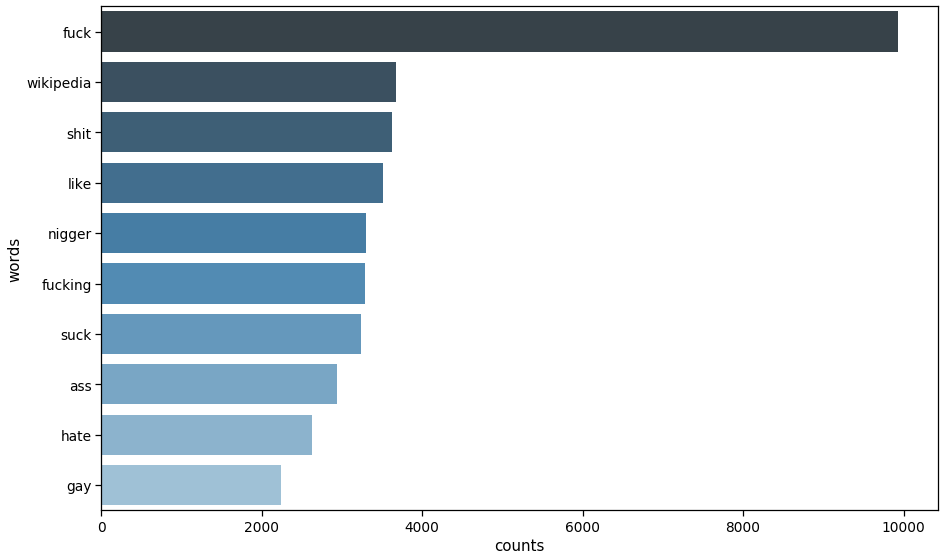

In [46]:
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(train[train.toxic == 1].clean_comments)
plot_most_common_words(count_data, count_vectorizer)

Comments consits mostly of vulgar and insulting phrases as we could expect from the wordcloud analysis. Insulters clearly have unsophisticated vocabulary.

Next step would be to compute Latent Dirchlet Allocation to identify topics and words associated with them.

In [50]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
number_topics = 5
number_words = 10

lda = LDA(n_components=number_topics,
          learning_method = 'batch',
          learning_decay = 0.7,
          learning_offset=10.0,
          max_iter=10,
          batch_size=256,
          evaluate_every=-1)
lda.fit(count_data)

print_topics(lda, count_vectorizer, number_words)


Topic #0:
shit die fat cunt jew bullshit bark nipple eat cock

Topic #1:
moron hi wikipedia balls aids dickhead asshole bad care dont

Topic #2:
fuck ass hate gay bitch pig penis wanker sucks fucker

Topic #3:
nigger faggot wikipedia like stop page stupid article people fag

Topic #4:
suck like fucking people page damn want know going dick


We can see that those comments focuses on insulting others and in particular few, mentioned before groups. However, just displaying most important words in each topic does not give us any additional intel so we will try visualizing those topics.

#### Create LDA visualization

We will use pyLDAvis library and objects created above. We recommend not to compute following cell again, because computing time exceeds 30 minutes - and load already created pickle instead. 

In [0]:
# uncomment lines below to compute LDAvis object and save it to a pickle
# LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

# Save it to a pickle
# with open('drive/My Drive/Toxic_Comments/objects/LDAvis.pickle', 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)

Load object from pickle:

In [0]:
with open('drive/My Drive/Toxic_Comments/objects/LDAvis.pickle', 'rb') as f:
    LDAvis_loaded= pickle.load(f)

Graph below alows us to better understand topics in our corpus

In [58]:
pyLDAvis.display(LDAvis_loaded)

We can explore words in each topic and the similarity between topics. However, apart of the target group they are insulting we cannot name any particular subject of discussion based on that.

### Sentiment analysis

In the next step we will compute sentiment of all comments in the corpus using VADER library.

We recommend to omit the following step (it takes several minutes to compute) and move straight to the cell in which we load file with already computed sentiment.

In [0]:
analyser = SentimentIntensityAnalyzer()

In [0]:
compval1 = [ ]
i=0
while (i<len(train)):
    k = analyser.polarity_scores(train.iloc[i]['clean_comments'])
    compval1.append(k['compound'])
    i = i+1

compval1 = np.array(compval1)
train['vader'] = compval1

train.to_csv('drive/My Drive/Toxic_Comments/train_vader.csv', sep='\t', encoding='utf-8')

Load already computed sentiment

In [0]:
train_vader = pd.read_csv('drive/My Drive/Toxic_Comments/train_vader.csv', sep='\t')

How does the distribution of the sentiment on the whole corpus looks like?

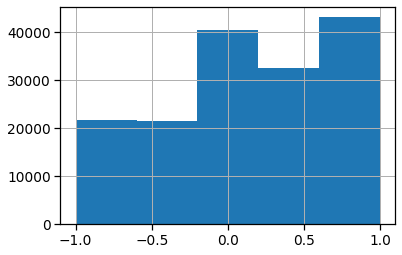

In [66]:
train_vader.vader.hist(bins = 5)

Most of them are either neutral or positive - there is a hope for those Wikipedia pages!

But what if we look only on the toxic comments?

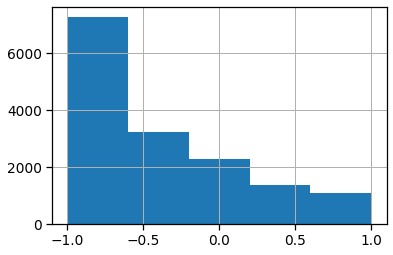

In [67]:
train_vader[train_vader.toxic == 1].vader.hist(bins = 5)

Right skewed distribution clearly represent negative polarity of sentiment among toxic comments.

How is the sentiment correlated with each toxic category?

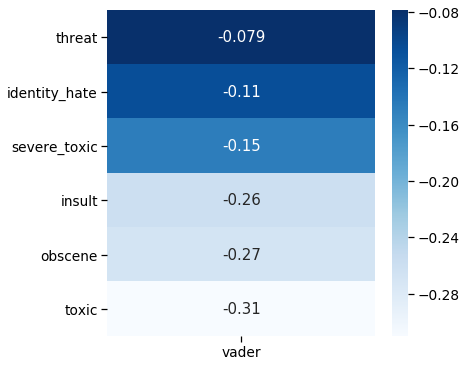

In [69]:
temp_df = train_vader[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'vader']]
corr=temp_df.corr()

plt.figure(figsize=(6,6))
sns.heatmap(corr[['vader']].iloc[:-1,].sort_values(by=['vader'],ascending=False),
            cmap="Blues",
            annot=True)

*Toxic*, *obscene* and *insult* are the most clearly negatively correlated with sentiment. Suprisingly, *severe toxic* is less negatively correlated with sentiment than just *toxic*  - perhaps comments which are really toxic are not simply negative but touch some deep feelings. 

### Length to category correlation

Finally let's simply investigate how the length of comments is correlated with category.

In [0]:
train['comment_length']  = train['clean_comments'].str.len()

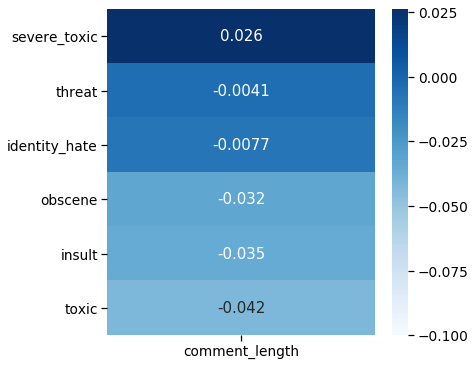

In [71]:
temp_df = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'comment_length']]
corr=temp_df.corr()

plt.figure(figsize=(6,6))
sns.heatmap(corr[['comment_length']].iloc[:-1,].sort_values(by=['comment_length'],ascending=False),
            vmin=-0.1,
            cmap="Blues",
            annot=True);

Minor correlations are visible, with severe_toxic being the only category with positive correlation - we may suspect that those really toxic comments are longer than any other.

# Preprocessing

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tokenize data

In [0]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[list_classes].values
y_test = test_set[list_classes].values
list_sentences_train = train["clean_comments"]
list_sentences_test = test_set["clean_comments"]

In [0]:
max_features = 30000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

word_index = tokenizer.word_index
vocab_size=len(word_index)
print(f"Our vocabulary size: {vocab_size}")

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

Our vocabulary size: 209630


Save the tokenizer pickle

In [0]:
with open('drive/My Drive/Toxic_Comments/objects/tokenizer_30000.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('drive/My Drive/Toxic_Comments/objects/tokenizer_30000.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

Pad sentences to ensure that all input has the same length

In [0]:
max_length = 250
padding_type='post'
X_train = pad_sequences(list_tokenized_train, maxlen=max_length, padding=padding_type)
X_test = pad_sequences(list_tokenized_test, maxlen=max_length, padding=padding_type)

# Classifier

In [0]:
from tensorflow.keras.layers import Dense, Flatten, LSTM, GRU, Embedding, Dropout, Activation, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import model_from_json
from sklearn.metrics import roc_auc_score

def save_model(model,name):
    json_string = model.to_json()
    open('drive/My Drive/Toxic_Comments/model_files/'+name+'_architecture.json', 'w').write(json_string)
    model.save_weights('drive/My Drive/Toxic_Comments/model_files/'+name+'_weights.h5')
    
def load_model(name):
    model = model_from_json(open('drive/My Drive/Toxic_Comments/model_files/'+name+'_architecture.json').read())
    model.load_weights('drive/My Drive/Toxic_Comments/model_files/'+name +'_weights.h5')
    return(model)

Download GloVe embeddings

In [0]:
embedding_dim = 100

In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-01-24 10:40:13--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   178MB/s    in 1.9s    

2020-01-24 10:40:15 (178 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



## Create network architecture

We experimeted with many architectures, however the one below gave us the best results. It is worth mentioning that simple CNN had the best results on training set, but did poorly on the test set.

Our architecture consists of: 

*   GloVe embeddings (not trainable) followed by dropout
*   1-dimensional convolution with maxpooling as an embedding encoder
*   Bidirectional Gated Recurrent Unit with 128 units followed by dropout and maxpooling
*   Dense layer
*   Output layer with sigmoid activation

Whole network consists of 457,606 trainable parameters.

Network will be optimized by Adam optimizer on default settings.

As it is multi-label classification problem we used binary crossentropy loss.

In [0]:
model = Sequential([
                    
    Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    Dropout(0.1),

    Conv1D(256, 5),
    MaxPooling1D(pool_size=4),

    Bidirectional(GRU(128, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)),
    Dropout(0.1),
    GlobalMaxPooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.1),

    Dense(6, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Below we can see the architecture in details

In [0]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 250, 100)          20963100  
_________________________________________________________________
dropout_63 (Dropout)         (None, 250, 100)          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 246, 256)          128256    
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 61, 256)           0         
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 61, 256)           295680    
_________________________________________________________________
dropout_64 (Dropout)         (None, 61, 256)           0         
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 256)             

Train model

In [0]:
num_epochs = 10
batch_size = 512
history = model.fit(X_train,
                    y_train,
                    epochs=num_epochs,
                    batch_size = batch_size,
                    verbose=1,
                    shuffle=True)

Train on 159571 samples
Epoch 1/10
159571/159571 [==============================] - 63s 393us/sample - loss: 0.0837 - acc: 0.9733
Epoch 2/10
159571/159571 [==============================] - 59s 372us/sample - loss: 0.0573 - acc: 0.9795
Epoch 3/10
159571/159571 [==============================] - 61s 381us/sample - loss: 0.0523 - acc: 0.9807
Epoch 4/10
159571/159571 [==============================] - 60s 378us/sample - loss: 0.0486 - acc: 0.9819
Epoch 5/10
159571/159571 [==============================] - 61s 379us/sample - loss: 0.0455 - acc: 0.9828
Epoch 6/10
159571/159571 [==============================] - 62s 385us/sample - loss: 0.0435 - acc: 0.9834
Epoch 7/10
159571/159571 [==============================] - 61s 380us/sample - loss: 0.0409 - acc: 0.9844
Epoch 8/10
159571/159571 [==============================] - 61s 380us/sample - loss: 0.0390 - acc: 0.9850
Epoch 9/10
159571/159571 [==============================] - 61s 380us/sample - loss: 0.0370 - acc: 0.9856
Epoch 10/10
159571/159

In [0]:
score = model.evaluate(X_test, 
                       y_test,
                       batch_size = 512,
                       verbose = 1)

63978/63978 [==============================] - 7s 108us/sample - loss: 0.0827 - acc: 0.9678


We achieved great accuracy on training set 98.61%, accuracy on the test set is not much worse: 96.78%

In the Kaggle challenge ROC AUC score is used so we can also compute that.

In [0]:
y_eval = model.predict(X_test)

In [0]:
print(f"Achieved ROC AUC score: {round(roc_auc_score(y_test, y_eval),5)*100}%")

Achieved ROC AUC score: 96.953%


In [0]:
save_model(model, "cnn_gru_glove_9678")

# Exploring embeddings


In the beginning we trained our own embeddings, the accuracy was better on GloVe embeddings so we used them. However, in the attachments we included files with our embeddings that allow you to visualize them using Tensorflow Projector.

To use it you will need to go to https://projector.tensorflow.org/ and load files from attachments. (vecs.tsv and meta.tsv)

After you upload the files you should see something like this:

![alt text](https://drive.google.com/uc?id=1s8Uak7l8KavLWdfqNoVwntNQNFofwlyv)


In [0]:
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(20000, 128)


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')